## [E08] 뉴스요약하기

- attention을 활용한 seq2seq 모델을 사용하여 뉴스를 요약한다.
- 뉴스의 text를 headlines로 요약하도록 학습을 시킨다. 이렇게 학습시킨 encoder output과 hidden state, cell state를 사용하여서 인퍼런스 모델을 설계하여 뉴스를 요약해본다.
- RNN모델은 Recurrent Dropout을 사용하여 drop out을 시킨다.model3개를 만들어서 테스트해본다.
    > model1은 Recurrent Dropout을 encoder, decoder 모두에 적용시키고, 
    > model2는 encoder에만 Recurrent Dropout을 적용시킨다. 
    > model3은 Recurrent Dropout을 적용시키지 않는다.

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Step1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(5)

,headlines,text
15964,Bureaucrats will pay the price if they are cor...,In an apparent dig at bureaucrats close to Odi...
76194,Former HC judge Karnan works on memoir in jail,"Retired judge CS Karnan, who is India's first ..."
69987,Maha govt to open 3 new NICUs to curb child mo...,The Maharashtra government will be opening thr...
285,"Aamir, Naseeruddin, Navjot Sidhu are traitors:...",RSS leader Indresh Kumar on Monday said that a...
86803,Jio showing prepaid customers as postpaid in J...,Airtel has demanded license cancellation of Re...


In [5]:
data.shape # 98401개의 데이터

(98401, 2)

이 데이터는 기사의 본문에 해당하는 text와 headlines 두가지 열로 구성되어있다.  
- 추상적 요약: text 본문을, headlines를 이미 요약된 데이터로 삼아서 모델을 학습
- 추출적 요약: 오직 text열을 사용

### Step 2) 데이터 전처리하기 (추상적 요약)
#### 2-1) 중복 샘플과 Null값 제거
#### 2-2) 텍스트를 정규화하거나 정제
#### 2-3) 불용어 제거
( 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보기)

#### 2-1) 중복 샘플과 Null 값 제거

In [6]:
print("전체 데이터:", data.shape[0])
print("text 열의 중복 제거한 유일한 데이터의 수: ", data["text"].nunique())
print("headlines 열의 중복 제거한 유일한 데이터의 수: ", data["headlines"].nunique())

전체 데이터: 98401
text 열의 중복 제거한 유일한 데이터의 수:  98360
headlines 열의 중복 제거한 유일한 데이터의 수:  98280


In [7]:
data.drop_duplicates(subset = ['text'], inplace=True) # text 컬럼이 중복되는 데이터 제거
data.drop_duplicates(subset = ['headlines'], inplace=True) # headlines 컬럼이 중복되는 데이터 제거

print('전체 샘플수 :', data.shape[0])

전체 샘플수 : 98262


text와 headlines 모두 중복된 데이터가 있었다. 각 컬럼들의 중복된 데이터를 제거해서 전체 데이터 98401개에서 98262개로 줄어들었다.

In [8]:
print(data.isnull().sum()) # headlines와 text 컬럼 각각 결측치는 없었다.

headlines    0
text         0
dtype: int64


#### 2-2) 텍스트를 정규화하거나 정제 & 2-3) 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english')[:10])

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


데이터 전처리 함수의 코드는  
- 텍스트 소문자화
- html 태그 제거
- 괄호로 닫힌 문자열 제거
- 쌍따옴표 " 제거
- 약어 정규화
- 소유격 제거 
- 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
- m이 3개 이상이면 2개로 변경

#### 텍스트 소문자화

In [11]:
sentence=data["text"][10].lower() # 텍스트 소문자화
sentence

"two minor cousins in uttar pradesh's gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. the cousins revealed their ordeal to the police and child welfare committee after being brought back to gorakhpur from nepal, where they had fled to escape the torture."

#### html 태그 제거
- 아래와 같이 태그에 들어가는 < 표시를 데이터에서 찾을 수 없는 것으로 보아서 태그는 없는 것 같다. 임의로 만든 태그가 포함된 문장을 BeautifulSoup를 사용해서 태그를 제거해보자.

In [12]:
data.loc[data["text"].str.contains("<")] # 태그에 들어가는 표시가 없다. html 태그가 없다

,headlines,text


In [13]:
sentence = BeautifulSoup("<h1>안녕하세요</h1>", "lxml").text 
# <br />, <a href = ...> 등의 html 태그 제거
# BeautifulSoup라이브러리로 파싱해서 text만 가져온다. 그렇게 태그를 제거한다.
sentence 

'안녕하세요'

#### 괄호제거
- 괄호로 닫힌 문자열을 삭제한다. 아래 원본 데이터의 (IISc)가 삭제된 것을 볼수있다.

In [14]:
data["text"][100]

'German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢Â\x82Â¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.'

In [15]:
sentence = re.sub(r'\([^)]*\)', '', data["text"][100])
sentence 

'German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢Â\x82Â¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science , it provides design and sign-off tools for automotive electronics.'

#### 쌍따옴표 제거

In [16]:
re.sub('"','','그는 "안녕"이라고 말했다.') # 쌍따옴표를 제거한다.

'그는 안녕이라고 말했다.'

#### 약어 정규화
데이터의 일부를 뽑아서 정규화 사전과 불용어를 적용해보려고 데이터를 골라보고 있는데 아래와 같이 apostrophe(') 앞에 \\ (역슬러시) 표시가 있는 것을 확인할 수 있었다. 아마도 apostrophe를 escape 문자로 만들기 위해서 표기한 것 같다. __역슬러시가 들어간 데이터도 텍스트 정규화가 이뤄지는지 테스트__ 를 해보았다. 아래와 같이 정상적으로 텍스트 정규화가 이뤄지는 것을 확인 할수 있었다.

In [17]:
data["text"][1000]

'On being asked about sunstrike break in the first New Zealand-India ODI, India captain Virat Kohli said, "I had never experienced it in my life [before]." "I actually got out in a game in 2014 because the sun was in my eyes. This rule [play stopping because of sun] wasn\'t there then. I\'m glad there\'s a rule now," Kohli added.'

In [18]:
sentence = ' '.join([contractions[t] if t in contractions else t for t in data["text"][1000].split(" ")]) # 약어 정규화  
sentence

'On being asked about sunstrike break in the first New Zealand-India ODI, India captain Virat Kohli said, "I had never experienced it in my life [before]." "I actually got out in a game in 2014 because the sun was in my eyes. This rule [play stopping because of sun] was not there then. I am glad there is a rule now," Kohli added.'

#### 소유격 제거

In [19]:
sentence = re.sub(r"'s\b","", "Sunny's room") # 's\b-> 's한칸 여백은 소유격이므로 제거
sentence

'Sunny room'

#### 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
- 아래의 텍스트 데이터의 Ã¢Â\x82Â¹6.3 을 공백으로 변환했다.

In [20]:
data["text"][100]

'German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢Â\x82Â¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.'

In [21]:
re.sub("[^a-zA-Z]", " ", data["text"][100]) 
# ^은 not을 뜻하고 a-zA-Z은 소문자 알파벳과 대문자 알파벳이 아닌 문자는 
# 모두 공백으로 바꾸는 함수이다.

'German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru based deep tech startup SimYog  SimYog has raised about           crore in the funding round  with participation from early stage venture capital firm Ideaspring Capital  Incubated at the Indian Institute of Science  IISc   it provides design and sign off tools for automotive electronics '

#### m이 3개 이상이면 2개로 변경

In [22]:
re.sub('[m]{2,}', 'mm', "ummmmmmm yeah")

'umm yeah'

#### 불용어 제거
- 원본 데이터의 to, from, for등이 삭제된 것을 알수 있다.

In [23]:
data["text"][1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [24]:
# 문장의 단어(word)의 길이가 1 이상이고 
# NLTK의 stopwords에 포함 안된 단어만 다시 문장으로 만든다.
' '.join(word for word in data["text"][1].split() if not word in stopwords.words('english') if len(word) > 1)


"Kunal Shah's credit card bill payment platform, CRED, gave users chance win free food Swiggy one year. Pranav Kaushik, Delhi techie, bagged reward spending 2000 CRED coins. Users get one CRED coin per rupee bill paid, used avail rewards brands like Ixigo, BookMyShow, UberEats, Cult.Fit more."

In [25]:
# 데이터 전처리 함수, 위의 코드들을 하나의 함수로 모아서 정리된 코드이다.
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

headlines(요약 데이터)의 stopword를 제거 해야할지 판단하기 위해서 아래와 같이 문장의 길이를 숫자로 표현해보았다. 

In [26]:
data["len_text"]=data["text"].map(lambda x: len(x.split(" ")))
data["len_headlines"]=data["headlines"].map(lambda x: len(x.split(" ")))
print(data.len_text.max(), data.len_headlines.max())
print(data.len_text.min(), data.len_headlines.min())

92 18
1 1


In [27]:
data.loc[data["len_text"]==1] # 무의미한 데이터로 보인다 삭제한다.

,headlines,text,len_text,len_headlines
52,headlines,text,1,1


In [28]:
data=data.drop(52).reset_index(drop=True) # 52번 인덱스를 삭제하고 인덱스를 다시 reset한다. 

stopword를 보면 관사, 전치사 등이 포함된 것을 알수 있다. 우리는 요약된 문장이 자연스럽게 연결된 문장이기를 원하기 때문에 headlines에는 stopword가 포함되어야한다고 생각한다.

In [29]:
# preprocess_sentence 함수 적용
data["text"]=data["text"].map(lambda x: preprocess_sentence(x))
data["headlines"]=data["headlines"].map(lambda x: preprocess_sentence(x, False))

In [30]:
data['text'][0] # 데이터가 전처리 된 것을 알수 있다.

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [31]:
data.replace('', np.nan, inplace=True) # 빈 값을 Null로 변환

In [32]:
data.isnull().sum() # 결측치는 없다.

headlines        0
text             0
len_text         0
len_headlines    0
dtype: int64

문장 최대길이 정하기

텍스트의 최소 길이 : 38
텍스트의 최대 길이 : 92
텍스트의 평균 길이 : 58.43092376426049
요약의 최소 길이 : 3
요약의 최대 길이 : 18
요약의 평균 길이 : 9.580657636295173


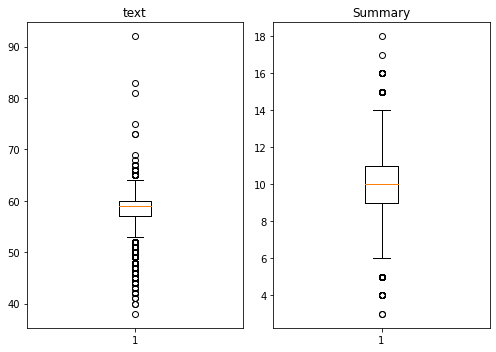

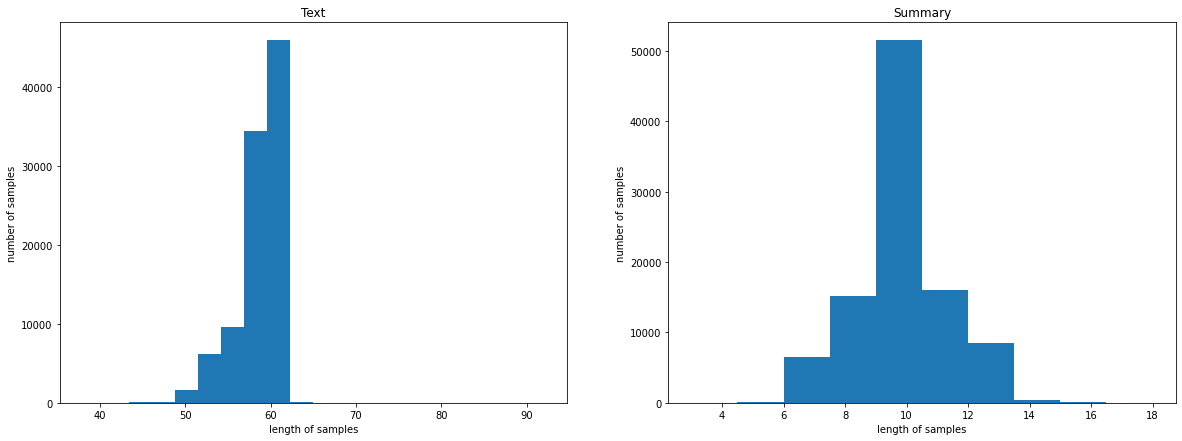

In [33]:
# 길이 분포 출력
import matplotlib.pyplot as plt

print('텍스트의 최소 길이 : {}'.format(data["len_text"].min()))
print('텍스트의 최대 길이 : {}'.format(data["len_text"].max()))
print('텍스트의 평균 길이 : {}'.format(data["len_text"].mean()))
print('요약의 최소 길이 : {}'.format(data["len_headlines"].min()))
print('요약의 최대 길이 : {}'.format(data["len_headlines"].max()))
print('요약의 평균 길이 : {}'.format(data["len_headlines"].mean()))

plt.figure(figsize=(7,5))
plt.subplot(1,2,1)
plt.boxplot(data["len_text"])
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(data["len_headlines"])
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Text')
plt.hist(data["len_text"], bins = 20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(1,2,2)
plt.title('Summary')
plt.hist(data["len_headlines"], bins = 10)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

[E06_네이버 영화리뷰를 활용한 감정분류](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/%5BE06%5Dsentiment_classification%20_ver2.ipynb)의 문장길이는 일반인들이 쓰는 리뷰라서 규격이 제각각이었고 한단어(ㅋㅋㅋ, 굿, 최고)로 이루어진 댓글이 많았다. 하지만 뉴스기사는 긴 기사도 있지만 대체적으로 60단어로 이루어진 기사가 많고 아무리 짧은 기사라고 할지라도 40단어 이상이다. 어떤 글을 수집했느냐에 따라서 문장 길이의 분포가 달라질 수 있다는 것을 알수 있었다.

In [34]:
# 임의로 정한 길이
text_max_len,summary_max_len=62,13
cnt=data.loc[data["len_text"]<text_max_len].shape[0]
summary_cnt=data.loc[data["len_headlines"]<summary_max_len].shape[0]

print("text 전체 샘플 중 길이가 %d 이하인 샘플의 비율: %f "%(text_max_len, cnt/data.shape[0]))
print("text 전체 샘플 중 길이가 %d 이하인 샘플의 비율: %f "%(summary_max_len, summary_cnt/data.shape[0]))

text 전체 샘플 중 길이가 62 이하인 샘플의 비율: 0.993354 
text 전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.975708 


text_max_len, summary_max_len보다 길면 제외하는 방법으로 정제를 한다. 
- 감정분석과 달리 텍스트를 생성해내는 모델이기 때문에 길이가 길면 학습데이터에서 제외한다. 생각해보면 가사 생성기의 모델에서도 길이가 길면 삭제했다.

In [35]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98081


In [40]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,len_text,len_headlines,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,60,13,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,60,12,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,60,9,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,60,9,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,60,13,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [43]:
# 인코더의 입력, 디코더의 입력, 디코더의 레이블을 각각 Numpy array타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


### 훈련데이터와 테스트 데이터 분리

In [44]:
indices = np.arange(encoder_input.shape[0]) # 간격이 1인 0~ 데이터개수 만큼의 배열 생성
np.random.shuffle(indices) # 랜덤한 순서가 되도록 섞는다
print(indices)

[58695 88480 97650 ...   675 16644 15409]


In [45]:
# encoder의 입력과 decoder의 입력과 라벨을 indices 순서에 맞춰준다.

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [46]:
# 랜덤으로 섞인 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터를 분리한다.
test_size=int(len(encoder_input)*0.2)
print("테스트 데이터의 개수: ", test_size)

테스트 데이터의 개수:  19616


In [47]:
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_target_train = decoder_target[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_target_test = decoder_target[-test_size:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78465
훈련 레이블의 개수 : 78465
테스트 데이터의 개수 : 19616
테스트 레이블의 개수 : 19616


훈련 데이터 78465개, 테스트 데이터 19616개가 나뉘어졌다.

### Tokenizer를 사용하여 단어사전(vocabulary)만들고 정수 인코딩한다.

In [48]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [55]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 사전(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 사전에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 사전에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 사전(vocabulary)의 크기 : 69447
등장 빈도가 7번 이하인 희귀 단어의 수: 48789
단어 사전에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20658
단어 사전에서 희귀 단어의 비율: 70.2535746684522
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8599154170132883


등장빈도가 7번 이하로 쓰여진 희귀 단어가 단어 사전에서 차지하는 비율은 70.25%를 차지한다. 즉 많은 양이 쓰여진다. 그러나 훈련데이터에서는 겨우 3.85% 사용되어진다. 6이하로 쓰여진 희귀 단어를 삭제하면 단어사전의 크기를 70.25% 절약가능하고 훈련데이터는 3.85%의 손실을 보게 된다. 절약할 수 있는 컴퓨팅 파워에 비해 손실이 매우 적어서 희귀단어는 지우는 쪽이 더 나아보인다.

- Tokenizer의 num_words=20658로 지정해서 7번 이하로 등장한 희귀단어를 제외시키자.

In [56]:
src_vocab = 20658
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [57]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4807, 842, 152, 15, 13313, 18381, 92, 1572, 63, 1736, 1167, 3508, 8, 1660, 4923, 374, 1402, 273, 1862, 1615, 764, 1279, 679, 56, 8003, 458, 1484, 953, 18381, 361, 9, 5681, 1712], [3850, 1283, 28, 99, 13314, 599, 7, 1874, 173, 1089, 19, 203, 2, 4113, 12913, 12914, 28, 99, 1, 3304, 279, 2, 1279, 261, 320, 43, 261, 134, 1903, 514], [216, 243, 277, 98, 6114, 2032, 33, 567, 9600, 85, 2082, 1322, 107, 346, 10216, 153, 108, 931, 30, 5180, 7662, 455, 53, 95, 1696, 5286, 7228, 190, 1367, 39, 7, 442, 612, 346, 1519]]


summary데이터(headlines)에 대해서도 위와 동일한 작업을 수행한다.

In [58]:
tar_tokenizer = Tokenizer() # target tokenizer
tar_tokenizer.fit_on_texts(decoder_input_train) # decoder_input_train을 넣어준다.


In [62]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 사전(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 사전에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 사전에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 사전(vocabulary)의 크기 : 30112
등장 빈도가 5번 이하인 희귀 단어의 수: 19683
단어 사전에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10429
단어 사전에서 희귀 단어의 비율: 65.36596705632306
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.661685978905759


summary 데이터의 등장빈도가 5번 이하인 희귀 단어는 전체 단어사전의 65.36%를 차지한다. 전체 summary 데이터셋에서 희귀단어가 등장하는 빈도는 4.66%이다. 이 단어들을 제거해도 훈련 데이터가 크게 손실이 갈것 같지는 않다. 단어사전의 크기를 10429로 제한해서 토크나이저를 진행한다.

In [63]:
tar_vocab = 10429
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3691, 1527, 1953, 78, 749, 3, 1074, 23, 2011], [1, 49, 5635, 262, 358, 259, 35, 1346, 6, 815, 315], [1, 9537, 1584, 83, 5, 2701, 258, 9538, 697], [1, 1895, 3386, 2133, 147, 178, 14, 722, 698], [1, 22, 37, 908, 119, 5636, 28, 115, 7, 154]]
target
decoder  [[3691, 1527, 1953, 78, 749, 3, 1074, 23, 2011, 2], [49, 5635, 262, 358, 259, 35, 1346, 6, 815, 315, 2], [9537, 1584, 83, 5, 2701, 258, 9538, 697, 2], [1895, 3386, 2133, 147, 178, 14, 722, 698, 2], [22, 37, 908, 119, 5636, 28, 115, 7, 154, 2]]


인코딩 작업은 끝났고, 너무 짧거나 빈 문장이 샘플링 되지는 않았는지 체크해보자.
요약문의 길이가 0이 된 샘플의 인덱스를 받아오자. (단 지금 특수토큰(sostoken, eostoken)이 추가되었으므로 요약문의 길이가 0인 경우에도 길이가 1로 나올 것을 주의하자.

In [64]:
# 길이가 1인 문장의 index를 각각 저장한다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# drop_train에 포함되지 않은 인덱스를 가진 문장만 저장한다.
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# drop_test에 포함되지 않은 인덱스를 가진 문장만 저장한다.
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78465
훈련 레이블의 개수 : 78465
테스트 데이터의 개수 : 19616
테스트 레이블의 개수 : 19616


삭제할 데이터가 없이 모두 데이터가 들어있다.

-----------------------------

### 패딩하기

In [65]:
# 앞에서 정했던 text_max_len에 맞춰서 패딩을 한다
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

# 앞에서 정했던 summary_max_len에 맞춰서 패딩을 한다
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

인코더 설계

In [109]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention

#### 모델1. encoder의 recurrent dropout = 0.4, decoder의 recurrent dropout=0.2 훈련
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4

In [111]:
embedding_dim = 128
hidden_size = 256
dropout_rate=0.4
re_dropout_rate=0.4
re_dropout_rate2=0.2

# 인코더 설계 시작
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
    
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
    
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,
                         dropout = dropout_rate, recurrent_dropout = re_dropout_rate)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
# 디코더 설계
decoder_inputs = Input(shape=(None,))
    
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
    
# 디코더의 LSTM
# 인코더의 LSTM과 거의 비슷하지만 inital_state에 
# 인코더의 LSTM3에서 출력되어진 state_h와 state_c를 꼭 입력해주어야함
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
    
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
    
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# rmsprop를 optimizer로 쓰고 cross entropy를 loss function으로 사용한다.
# adam도 한번 더 테스트해야겠다
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') 

# EarlyStopping을 해서 validation의 loss가 증가하는 현상이 2회 관찰되면 학습 중지 
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 62, 128)      2644224     input_31[0][0]                   
__________________________________________________________________________________________________
lstm_32 (LSTM)                  [(None, 62, 256), (N 394240      embedding_16[0][0]               
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

전체 데이터 78465를 batch size 256으로 나눠서 학습하므로 1epoch을 돌때 307 (306.50390625=78465/256을 올림)step을 간다. 

### 모델 1의 learning curve 시각화
- encoder의 recurrent dropout rate=0.4
- decoder recurrent dropout rate=0.2
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4

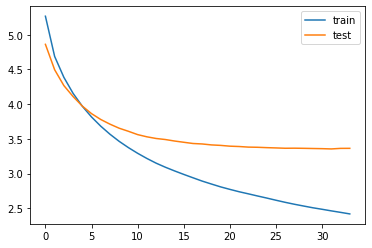

In [112]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


--------------------------------------------

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)- 모델1
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자

In [113]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [114]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [115]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [116]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [117]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : inquiry committee appointed jawaharlal nehru university upheld punishments recommended students umar khalid kanhaiya kumar connection event protesting afzal guru execution jnu panel recommended khalid imposing fine kanhaiya event anti national slogans allegedly raised 
실제 요약 : jnu panel upholds to umar khalid kanhaiya kumar 
예측 요약 :  jnu prof appointed as jnu director


원문 : former australian wicket keeper adam gilchrist tweeted indian batsman ms dhoni anything rules ground bat inside crease completing run gilchrist said reply person tweeted short run considered nd subsequent runs 
실제 요약 : it against the rules gilchrist on dhoni incomplete run 
예측 요약 :  dhoni and dhoni while batting at him


원문 : speaking incidents lynching country vice president venkaiah naidu said kill man call nationalist nationalism bharat mata ki jai wider meaning added societal behaviour change vice president said lynching linked political parties 
실제 요약 : those involved in lynching are not vice prez 
예측 요약 

-----------------------
### 모델2. decoder에서만 recurrent dropout rate(0.2)를 적용한 경우

- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 (모델1동일)

In [118]:
import tensorflow as tf
re_dropout_rate=0
re_dropout_rate2=0.2

# 인코더 설계 시작
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
    
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
    
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,
                         dropout = dropout_rate, recurrent_dropout = re_dropout_rate)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
# 디코더 설계
decoder_inputs = Input(shape=(None,))
    
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
    
# 디코더의 LSTM
# 인코더의 LSTM과 거의 비슷하지만 inital_state에 
# 인코더의 LSTM3에서 출력되어진 state_h와 state_c를 꼭 입력해주어야함
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
    
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
    
# 모델 정의
model1 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model1.summary()

# rmsprop를 optimizer로 쓰고 cross entropy를 loss function으로 사용한다.
# adam도 한번 더 테스트해야겠다
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') 

# EarlyStopping을 해서 validation의 loss가 증가하는 현상이 2회 관찰되면 학습 중지 
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

history1 = model1.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 62, 128)      2644224     input_36[0][0]                   
__________________________________________________________________________________________________
lstm_36 (LSTM)                  [(None, 62, 256), (N 394240      embedding_18[0][0]               
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

### 모델 2의 learning curve 시각화
- encoder의 recurrent dropout rate=0
- decoder recurrent dropout rate=0.2
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 모델1 동일

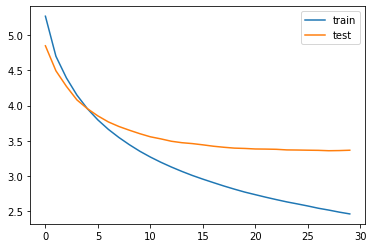

In [119]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()


--------------------------------------------

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)- 모델2
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자

In [120]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [121]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [122]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [123]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [124]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : inquiry committee appointed jawaharlal nehru university upheld punishments recommended students umar khalid kanhaiya kumar connection event protesting afzal guru execution jnu panel recommended khalid imposing fine kanhaiya event anti national slogans allegedly raised 
실제 요약 : jnu panel upholds to umar khalid kanhaiya kumar 
예측 요약 :  jnu body asks jnu to jnu students


원문 : former australian wicket keeper adam gilchrist tweeted indian batsman ms dhoni anything rules ground bat inside crease completing run gilchrist said reply person tweeted short run considered nd subsequent runs 
실제 요약 : it against the rules gilchrist on dhoni incomplete run 
예측 요약 :  dhoni should be used to bat in my life dhoni


원문 : speaking incidents lynching country vice president venkaiah naidu said kill man call nationalist nationalism bharat mata ki jai wider meaning added societal behaviour change vice president said lynching linked political parties 
실제 요약 : those involved in lynching are not vice prez 

----------------------------

### 모델3. recurrent dropout을 전혀 쓰지 않는 경우
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 모델1, 모델2와 동일

In [125]:
re_dropout_rate=0
re_dropout_rate2=0

# 인코더 설계 시작
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
    
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
    
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,
                         dropout = dropout_rate, recurrent_dropout = re_dropout_rate)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
# 디코더 설계
decoder_inputs = Input(shape=(None,))
    
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
    
# 디코더의 LSTM
# 인코더의 LSTM과 거의 비슷하지만 inital_state에 
# 인코더의 LSTM3에서 출력되어진 state_h와 state_c를 꼭 입력해주어야함
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
    
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
    
# 모델 정의
model1 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model1.summary()

# rmsprop를 optimizer로 쓰고 cross entropy를 loss function으로 사용한다.
# adam도 한번 더 테스트해야겠다
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') 

# EarlyStopping을 해서 validation의 loss가 증가하는 현상이 2회 관찰되면 학습 중지 
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

history1 = model1.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 62, 128)      2644224     input_41[0][0]                   
__________________________________________________________________________________________________
lstm_40 (LSTM)                  [(None, 62, 256), (N 394240      embedding_20[0][0]               
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

### 모델 3의 learning curve 시각화
- encoder의 recurrent dropout rate=0
- decoder recurrent dropout rate=0
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 (모델1, 모델2와 동일)

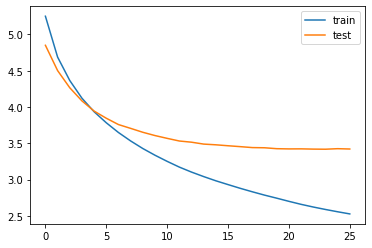

In [126]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()


--------------------------------------------

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)- 모델3
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자

In [127]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [128]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [129]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [130]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [133]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : inquiry committee appointed jawaharlal nehru university upheld punishments recommended students umar khalid kanhaiya kumar connection event protesting afzal guru execution jnu panel recommended khalid imposing fine kanhaiya event anti national slogans allegedly raised 
실제 요약 : jnu panel upholds to umar khalid kanhaiya kumar 
예측 요약 :  jnu students not to be removed from jan


원문 : former australian wicket keeper adam gilchrist tweeted indian batsman ms dhoni anything rules ground bat inside crease completing run gilchrist said reply person tweeted short run considered nd subsequent runs 
실제 요약 : it against the rules gilchrist on dhoni incomplete run 
예측 요약 :  dhoni reveals he was once asked to clean his own


원문 : speaking incidents lynching country vice president venkaiah naidu said kill man call nationalist nationalism bharat mata ki jai wider meaning added societal behaviour change vice president said lynching linked political parties 
실제 요약 : those involved in lynching are not 

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자

원문 : inquiry committee appointed jawaharlal nehru university upheld punishments recommended students umar khalid kanhaiya kumar connection event protesting afzal guru execution jnu panel recommended khalid imposing fine kanhaiya event anti national slogans allegedly raised    

실제 요약 : jnu panel upholds to umar khalid kanhaiya kumar    
모델 1 예측 요약 :  jnu prof appointed as jnu director   
모델 2 예측 요약 :  jnu body asks jnu to jnu students   
모델 3 예측 요약 :  jnu students not to be removed from jan   

----------------------------------------------------

원문 : former australian wicket keeper adam gilchrist tweeted indian batsman ms dhoni anything rules ground bat inside crease completing run gilchrist said reply person tweeted short run considered nd subsequent runs    
실제 요약 : it against the rules gilchrist on dhoni incomplete run    
모델 1 예측 요약 :  dhoni and dhoni while batting at him   
모델 2 예측 요약 :  dhoni should be used to bat in my life dhoni   
모델 3 예측 요약 :  dhoni reveals he was once asked to clean his own   



----------------------------

### 모델3. recurrent dropout을 전혀 쓰지 않는 경우
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 모델1, 모델2와 동일

In [125]:
re_dropout_rate=0
re_dropout_rate2=0

# 인코더 설계 시작
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
    
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
    
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,
                         dropout = dropout_rate, recurrent_dropout = re_dropout_rate)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
# 디코더 설계
decoder_inputs = Input(shape=(None,))
    
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
    
# 디코더의 LSTM
# 인코더의 LSTM과 거의 비슷하지만 inital_state에 
# 인코더의 LSTM3에서 출력되어진 state_h와 state_c를 꼭 입력해주어야함
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=re_dropout_rate2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
    
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
    
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
    
# 모델 정의
model1 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model1.summary()

# rmsprop를 optimizer로 쓰고 cross entropy를 loss function으로 사용한다.
# adam도 한번 더 테스트해야겠다
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') 

# EarlyStopping을 해서 validation의 loss가 증가하는 현상이 2회 관찰되면 학습 중지 
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

history1 = model1.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 62, 128)      2644224     input_41[0][0]                   
__________________________________________________________________________________________________
lstm_40 (LSTM)                  [(None, 62, 256), (N 394240      embedding_20[0][0]               
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

### 모델 3의 learning curve 시각화
- encoder의 recurrent dropout rate=0
- decoder recurrent dropout rate=0
- embedding_dim = 128,hidden_size = 256,dropout_rate=0.4 (모델1, 모델2와 동일)

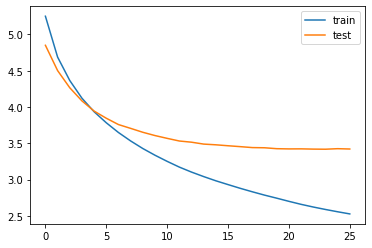

In [126]:
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()


--------------------------------------------

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)- 모델3
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자

In [127]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [128]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [129]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [130]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [133]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : inquiry committee appointed jawaharlal nehru university upheld punishments recommended students umar khalid kanhaiya kumar connection event protesting afzal guru execution jnu panel recommended khalid imposing fine kanhaiya event anti national slogans allegedly raised 
실제 요약 : jnu panel upholds to umar khalid kanhaiya kumar 
예측 요약 :  jnu students not to be removed from jan


원문 : former australian wicket keeper adam gilchrist tweeted indian batsman ms dhoni anything rules ground bat inside crease completing run gilchrist said reply person tweeted short run considered nd subsequent runs 
실제 요약 : it against the rules gilchrist on dhoni incomplete run 
예측 요약 :  dhoni reveals he was once asked to clean his own


원문 : speaking incidents lynching country vice president venkaiah naidu said kill man call nationalist nationalism bharat mata ki jai wider meaning added societal behaviour change vice president said lynching linked political parties 
실제 요약 : those involved in lynching are not 

### 모델1,2,3은 다소 오버피팅이 발생하였지만,  학습곡선은 안정적으로 수렴했다.  그러나 실제 요약문과 유사한 요약문장을 얻을 수 없었다.

원문 : world bank ceo said understands cricket loving nation hitting century important milestone said india secured th rank world bank ease business report also credited india achievement per capita income reforms taken last years    

실제 요약 : hitting is huge in cricket loving nation world bank    
모델 1 예측 요약 :  world is the world biggest asset ceo   
모델 2 예측 요약 :  we are the world bank of the world bank ceo   
모델 3 예측 요약 :  world bank has become world bank of world bank



원문 : pakistani maestro ghulam ali scheduled perform temple varanasi next month third year row ali performed temple despite protests shiv sena performance likely part opening ceremony sangeet scheduled april    
실제 요약 : pak singer ali to perform at varanasi temple    
모델 1 예측 요약 :  pak army chief to be part of lord ram rahim   
모델 2 예측 요약 :  pakistan releases its first ever national anthem   
모델 3 예측 요약 :  pak temple to be part of honour from airports   

원문 : chinese workers pakistan attacked policemen deployed security denied permission visit red light area without accompanied police said workers reportedly engaged construction workers later cut power supply police camp construction facility stopped work project    
실제 요약 : chinese workers attack pak cops over visit to red light area    
모델 1 예측 요약 :  chinese cops suspended for throwing stray dogs at border   
모델 2 예측 요약 :  chinese cops get stuck in indian chopper in pakistan   
모델 3 예측 요약 :  police to get security to avoid security forces   



원문 : aap leader kumar vishwas took twitter share video man speaking long english words wrote shashi tharoor brother lost kumbh festival found congratulations congress mp replied vishwas tweet hindi language saying better people becoming brothers talking alike    
실제 요약 : vishwas trolls tharoor over his english tharoor replies in hindi    
모델 1 예측 요약 :  aap leader shares pic of aap leader on his birth   
모델 2 예측 요약 :  aap mla slams aap leader for calling him flag   
모델 3 예측 요약 :  aap leader shares video of him dancing to aap   



원문 : united states america cricket association facing expulsion international cricket council sport global governing body revealed monday icc suspended board claimed body unity hold widespread authority country cricket activities    
실제 요약 : usa cricket body faces expulsion from icc    
모델 1 예측 요약 :  icc criticises us cricketers over playing abuse   
모델 2 예측 요약 :  icc to match fixing fixing offence in us   
모델 3 예측 요약 :  icc rules out of icc for st time in tests   

### Step 5. Summa을 이용해서 추출적 요약해보기

Summa의 summarize를 사용하여 추출적 요약을 해보자

In [143]:
from summa.summarizer import summarize

In [171]:
text2="aap leader kumar vishwas took twitter share video man speaking long english words wrote shashi tharoor brother lost kumbh festival found congratulations congress mp replied vishwas tweet hindi language saying better people becoming brothers talking alike"
print(summarize(text2, ratio=0.6))

In [175]:
text1="united states america cricket association facing expulsion international cricket council sport global governing body revealed monday icc suspended board claimed body unity hold widespread authority country cricket activities"
print(summarize(text1, ratio=0.6))

In [174]:
text3="chinese workers pakistan attacked policemen deployed security denied permission visit red light area without accompanied police said workers reportedly engaged construction workers later cut power supply police camp construction facility stopped work project"
print(summarize(text3, ratio=0.6))

In [173]:
text4="aap leader kumar vishwas took twitter share video man speaking long english words wrote shashi tharoor brother lost kumbh festival found congratulations congress mp replied vishwas tweet hindi language saying better people becoming brothers talking alike"
print(summarize(text4, ratio=0.6))

추상적 요약을 한 문장과 추출적 요약을 한 문장을 비교하기 위해서 위의 문장을 그대로 추출적 요약을 하려고 했으나 추출적 요약이 되지 않았다.

### 후기
- 지난 네이버 영화리뷰를 사용한 감정분류의 경우는 LSTM을 사용해서 시퀀스 데이터로 하나의 결과물을 출력(긍정 or 부정)을 했다면 오늘은 시퀀스 데이터를 사용해서 시퀀스 데이터를 출력하는 결과물을 내는 과제였다. 모델 loss의 learning curve는 잘 줄어들었으나 실질적인 요약이 비례하게 요약 성능이 좋아졌다는 느낌을 받기 어려웠다.
- recurrent dropout를 encoder와 decoder 모두 사용했던 모델 1의 loss가 가장 많이 줄어들어서 가장 좋은 성능을 보일 것이라 생각했지만 성능이 뛰어나다는 느낌을 받기는 어려웠다. 다만 성능이 개선되는 것이 다른 하이퍼 파라미터 hidden size와 임베딩 차원을 조절하는 것보다 크게 개선되는 것인지는 추가적인 실험이 필요하다는 생각이 들었다.
- recurrent drop out은 모두 0으로 두고 dropout을 0.7로 늘려서 학습을 시도했었다. 성능이 전혀 개선 되지 않아서 불필요하다고 생각해서 모델을 코드에서 지웠지만 RNN에서는 drop out이 성능 개선에 도움이 되지 않는다는 것을 알게 되는 계기가 되었다.